# **Data Collection**
---

## Objective

- Clean and prepare the provided image dataset

## Inputs

- A folder containing a specific amount of correctly labeled subfolders corresponding to the amount of pets to distinguish
- Several hundred preprocessed png images (size 128x128) in each subfolder, showing a snapshot af a pet walking up to a bowl

## Outputs

- A cleaned dataset in the folder `inputs/datasets/pets` split into `train`/`validation`/`test` subfolders
- The file `class_dict.pkl` containing the indexed classes
- The file `split_folder_ratio.pkl` containing the names of the folders and the ratios with which they have been split

---
## Preparation

### Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from PIL import Image
import shutil
import random


sns.set_style("white")

### Set the correct working directory

In [4]:
# Check the current working directory
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [5]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

It was decided that all incoming images would be RGB PNG images with an aspect ratio of 1:1 and the dimensions 128x128.

In [6]:
from src.utils_notebooks import print_err, print_warn, get_user_confirmation

dataset_name = "pets"
full_dataset_path = os.path.normpath(
    os.path.join(cwd, "inputs/datasets", dataset_name))
output_path = os.path.join(cwd, "outputs")

ORIG_IMG_DIMS = (128, 128)
ORIG_IMG_TYPE = 'png'

# The following line should show a list containing all the label names of the
# input dataset
os.listdir(full_dataset_path)

['test', 'train', 'validation']

---
## Step 1
### Check the directories and clean the images

In [40]:
from PIL import UnidentifiedImageError
from PIL import ImageOps


def check_folder_structure(path, expected_labels_num):
    """Check if the directory with the dataset exists and is complete

    Args:
        path (str): Full path to the dataset
        expected_labels_num (int): Amount of expected labels

    Returns:
        incomplete_dataset (bool): Flag showing if the dataset is complete
        None: If the directory couldn't be checked due to an error
    """

    if not os.path.isdir(path):
        print_err(
            f"The path {path} that should contain the labelled subfolders "
            f"doesn't exist."
        )
        return
    if len(os.listdir(path)) == 0:
        print_err(
            f"The path {path} that should contain the labelled subfolders is "
            f"empty."
        )
        return
    if not set(['train', 'test', 'validation']).isdisjoint(os.listdir(path)):
        print_err(
            f"The folder {
                path} seems to already contain the split dataset or a label "
            f" has been named 'train', 'test', or 'validation'."
        )
        return

    checked_root = False
    empty_label = False
    incomplete_dataset = False

    for root, dirs, files in os.walk(path):
        print(f"Checking the directory {root} ...")
        if not checked_root:
            checked_root = True
            # Check if all labels are present
            if len(dirs) != expected_labels_num:
                print_warn(
                    f"The labelled subfolders {
                        dirs} seem to be incomplete: there are "
                    f"{len(dirs)} instead of {expected_labels_num} labels.\n"
                    f"Continue cleaning and preparing the existing subfolders "
                    f"anyway? (y/n)"
                )
                if get_user_confirmation() == "y":
                    incomplete_dataset = True
                    continue
                else:
                    print("Cancelling the operation.")
                    return
        # Check if all labels contain files
        else:
            print(
                f'Amount of files with the label "{os.path.split(root)[1]}":' 
                f'\n{len(files)}'
            )
            if len(files) == 0:
                empty_label = True

    if empty_label:
        print_warn(
            f"There are labelled subfolders not containing any files.\n"
            f"Continue cleaning and preparing the other subfolders anyway? "
            f"(y/n)"
        )
        if get_user_confirmation() == "y":
            incomplete_dataset = True
        else:
            print("Cancelling the operation.")
            return

    return incomplete_dataset

In [9]:
def clean_images(path, expected_labels_num, dims, img_ext):
    """Check type and size of all images in dataset

    This function checks all files and fixes/deletes invalid files.

    Args:
        path (str): Full path to the dataset
        expected_labels_num (int): Amount of expected labels
        dims (tuple): Expected dimensions of all image files

    Returns:
        img_stats (dict): Dictionary with labels as keys and image amounts as 
            values
    """

    incomplete_dataset = check_folder_structure(path, expected_labels_num)

    if incomplete_dataset is None:
        return

    img_stats = {}
    wrong_aspect_ratio = False

    for label in os.listdir(path):
        counter = 0
        label_path = os.path.join(path, label)
        label_files = os.listdir(label_path)

        if len(label_files) == 0:
            print_warn(
                f"The path {label_path} that should contain the images of the "
                f"pet '{label}' is empty. Skipping to the next label."
            )
            continue

        for file in label_files:
            file_path = os.path.join(label_path, file)
            if not file.lower().endswith(img_ext):
                print_err(
                    f"{file} has an invalid file extension. Valid extensions "
                    f"are {img_ext}. Delete file (y) or cancel operation (n)?"
                )
                if get_user_confirmation() == "y":
                    print(f"Deleting invalid file {file} ...")
                    os.remove(file_path)
                    continue
                else:
                    print(
                        f"Cancelling the image cleaning process. Please make "
                        f"sure all input files have valid extensions and "
                        f"restart the process."
                    )
                    return
            else:
                try:
                    with Image.open(file_path) as img:
                        if not img.width == img.height:
                            print_warn(
                                f"{file_path}:\nThe image aspect ratio is not "
                                f"1:1. Pad and overwrite file? (y/n)"
                            )
                            if get_user_confirmation() == "y":
                                img = ImageOps.pad(
                                    img, dims, method=Image.LANCZOS,
                                    color="white"
                                )
                                img.save(file_path)
                                print(f"Padded and overwrote {file_path}")
                            else:
                                wrong_aspect_ratio = True
                                print("Skipping ...")
                                continue
                    counter += 1

                except (IOError, OSError, UnidentifiedImageError):
                    print_err(
                        f"Couldn't open {file_path}.\nDelete invalid file "
                        f"{file_path}? (y/n)"
                    )
                    if get_user_confirmation() == "y":
                        os.remove(file_path)
                        print(f"Deleted {file_path}")

                    continue

        img_stats[label] = counter

    if incomplete_dataset:
        print_warn(
            "The existing image files have been successfully prepared "
            "for splitting, but the dataset is incomplete.\nPlease "
            "re-check the amount of labels and image files before "
            "splitting the data and training the model."
        )
    if wrong_aspect_ratio:
        print_warn(
            "You chose to keep image files with the wrong aspect ratio.\n"
            "Please make sure all image files have the aspect ratio 1:1 "
            "before training the model."
        )

    print("\nFinished cleaning the image files.")

    return img_stats

In [10]:
img_stats = clean_images(full_dataset_path, expected_labels_num=3, 
                         dims=ORIG_IMG_DIMS, img_ext=ORIG_IMG_TYPE)

ERROR:
The folder d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets seems to already contain the split dataset or a label  has been named 'train', 'test', or 'validation'.


### Show a summary for all labels and image files

In [11]:
def plot_img_stats(img_stats, output_path, after_split=False):
    """Visualize the image stats in a bar plot

    Args:
        img_stats (dict): Dictionary with labels or split folders as keys and
            image amounts or label/image amount dictionaries as values
        output_path (str, optional): Path to save the plot graph. Defaults to
            output_path.
        after_split (bool, optional): If 'img_stats' has been created after the
            dataset has been split. Defaults to False.
    """

    if after_split:
        print("Distribution of labelled images after splitting the dataset:\n")
        df = pd.DataFrame(img_stats)
        ax = df.T.plot.bar()
        col = df["train"]
        suffix = '_after_split'

    else:
        print("Amount of labelled images in the input dataset:\n")
        df = pd.DataFrame.from_dict(img_stats, columns=["amount"],
                                    orient="index")
        col = df["amount"]
        ax = sns.barplot(
            y=img_stats.values(),
            x=img_stats.keys(),
            hue=img_stats.keys(),
            legend=False,
            palette="viridis",
        )
        suffix = ''

    for container in ax.containers:
        ax.bar_label(container)
    plt.xticks(rotation=0)
    plt.savefig(
        f"{output_path}/labels_distribution{suffix}.png",
        bbox_inches="tight",
        dpi=150
    )
    plt.show()

    col_idxmin, col_idxmax = col.idxmin(), col.idxmax()
    col_min, col_max = col.min(axis=0), col.max(axis=0)
    print("Label with the lowest amount of images:")
    print(f"{col_idxmin}: {col_min}")
    print("Label with the highest amount of images:")
    print(f"{col_idxmax}: {col_max}")
    print(
        f"Difference: {col_max - col_min}, "
        f"{col_idxmax} has {round(col_max / (col_min / 100) - 100)} % more "
        f"images than {col_idxmin}"
    )

The following plot shows whether the labels are balanced.

Distribution of labelled images after splitting the dataset:



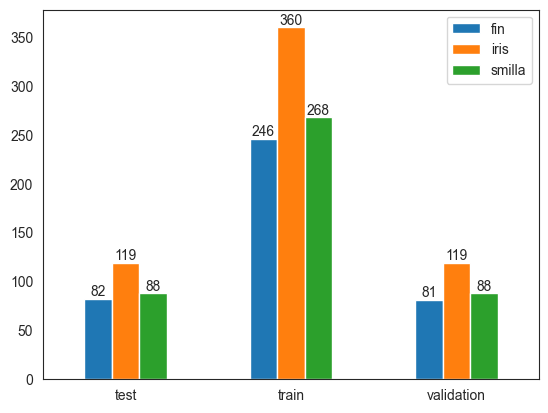

Label with the lowest amount of images:
fin: 246
Label with the highest amount of images:
iris: 360
Difference: 114, iris has 46 % more images than fin


In [18]:
plot_img_stats(img_stats, output_path)

---
## Step 2
### Split the dataset into 'train', 'validation', and 'test' sets

In [29]:
def split_dataset(path, split_folders, train_ratio, test_ratio, val_ratio):
    """Split all images into subsets

    Args:
        path (str): Path to the full dataset
        split_folders (list): Names and order of the subsets to be created
        train_ratio (float): Percentage of training data that the dataset 
            should contain
        test_ratio (float): Percentage of test data that the dataset should
            contain
        val_ratio (float): Percentage of validation data that the dataset
            should contain
    """

    # Check if ratios are valid
    if train_ratio + test_ratio + val_ratio != 1.0:
        print_err("Please make sure the file quantity ratios add up to 1.")
        return

    labels = os.listdir(path)

    # Check if the folder structure has already been created
    if not set(labels).isdisjoint(split_folders):
        print_err(
            "The dataset folder already contains the subfolders that you are "
            "trying to create. Please check your input folder."
        )
        return

    # Create folder structure
    for folder in split_folders:
        for label in labels:
            os.makedirs(name=os.path.join(path, folder, label))

    # Move image files to the appropriate subfolders
    for label in labels:
        label_path = os.path.join(path, label)
        label_files = os.listdir(label_path)
        random.shuffle(label_files)
        train_amount = int(train_ratio * len(label_files))
        test_amount = int(test_ratio * len(label_files))
        for counter, file in enumerate(label_files):
            file_path = os.path.join(label_path, file)
            if counter <= train_amount:
                shutil.move(file_path, os.path.join(path, "train", label,
                                                    file))
            elif counter <= train_amount + test_amount:
                shutil.move(file_path, os.path.join(path, "test", label, file))
            else:
                shutil.move(file_path, os.path.join(path, "validation", label,
                                                    file))

        # Delete folder if empty
        if not len(os.listdir(label_path)):
            os.rmdir(label_path)
        else:
            print(f"Unassigned files remaining in {label_path}")

    # Save all labels as classes in alphabetical order
    class_dict = {}
    for idx, label in enumerate(sorted(labels)):
        class_dict[idx] = label
    joblib.dump(class_dict, f"{output_path}/class_dict.pkl")
    print("Saved all classes in class_dict.pkl.")

    print("The dataset has been split successfully.")

    return

Here, we set a reasonable ratio for the subsets such as 60% - 20% - 20% and save it for later reference.

In [30]:
split_ratio = (0.6, 0.2, 0.2)
split_folders = ["train", "test", "validation"]
joblib.dump([split_folders, split_ratio], f"{output_path}/split_folder_ratio.pkl")

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/split_folder_ratio.pkl']

This function call splits the dataset on the disk into three subsets.

In [31]:
split_dataset(full_dataset_path, split_folders, *split_ratio)

Saved all classes in class_dict.pkl.
The dataset has been split successfully.


### Show a summary for the split dataset

In [15]:
def get_split_stats(path):
    """Create summary of the split dataset

    Args:
        path (str): Path to the full dataset

    Returns:
        dict: Dictionary with all folders, subfolders and image amounts in the
        dataset
    """
    
    img_stats = {}

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        folder_dir = os.listdir(folder_path)
        img_stats[folder] = {}

        for label in folder_dir:
            label_folder_dir = os.listdir(os.path.join(folder_path, label))
            img_stats[folder][label] = len(label_folder_dir)

    return img_stats

Distribution of labelled images after splitting the dataset:



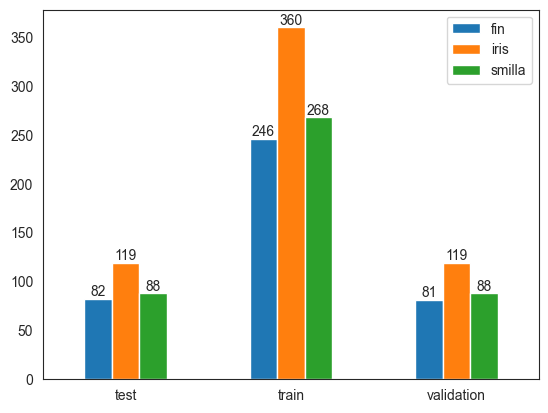

Label with the lowest amount of images:
fin: 246
Label with the highest amount of images:
iris: 360
Difference: 114, iris has 46 % more images than fin


In [17]:
# Create the summary dict
img_stats = get_split_stats(full_dataset_path)
# Save the summary dict for later reference
joblib.dump(img_stats, f"{output_path}/labels_distribution.pkl")
# Visualize the split dataset stats
plot_img_stats(img_stats, output_path, after_split=True)

## Conclusion

At this point, we should decide whether the amount and distribution of images is adequate for training the model.
If not, we should collect more image data or augment/reduce the data at a later stage.

If all steps in this notebook have been properly executed, we should now have a split dataset containing only valid image files sized `(128, 128)`.